<a href="https://colab.research.google.com/github/1eg1on/NLA-RL/blob/main/RL_Atari_Torch_render.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
from gym import spaces
import numpy as np
import os

In [2]:
import numpy as np
import os
os.environ.setdefault('PATH', '')
from collections import deque
import gym
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)



class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]

def make_atari(env_id, max_episode_steps=None):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

In [3]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [4]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [5]:
!apt-get install python-opengl -y

!apt install xvfb -y

!pip install pyvirtualdisplay

!pip install piglet


from pyvirtualdisplay import Display
Display().start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 92kB 9.8MB/s 


In [6]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

# Use the Baseline Atari environment because of Deepmind helper functions
env = make_atari("BreakoutNoFrameskip-v4")
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
#env.seed(seed)

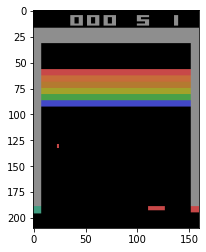

In [8]:
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
# for _ in range(40):
#     img.set_data(env.render('rgb_array')) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action = env.action_space.sample()
#     env.step(action)

In [9]:
num_actions = 4


# def create_q_model():
#     # Network defined by the Deepmind paper
#     inputs = layers.Input(shape=(84, 84, 4,))

#     # Convolutions on the frames on the screen
#     layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
#     layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
#     layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

#     layer4 = layers.Flatten()(layer3)

#     layer5 = layers.Dense(512, activation="relu")(layer4)
#     action = layers.Dense(num_actions, activation="linear")(layer5)

#     return keras.Model(inputs=inputs, outputs=action)

In [10]:
def compute_conv_dim(dim_size, kernel_size, padding, stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class Net(nn.Module):

      def __init__(self,out = num_actions):
              super(Net, self).__init__()

              self.out = out # the action space based output

              self.conv1 = nn.Conv2d(in_channels=4,out_channels=32,kernel_size = (8,8),stride = 4)
              self.conv_out = compute_conv_dim(84, kernel_size=8, padding=0, stride=4)

              self.conv2 = nn.Conv2d(32,64,kernel_size = (4,4),stride = 2)
              self.conv_out = compute_conv_dim(self.conv_out, kernel_size=4, padding=0, stride=2)

              self.conv3 = nn.Conv2d(64,64,kernel_size = (4,4),stride = 2)

              self.conv_out = compute_conv_dim(self.conv_out, kernel_size=4, padding=0, stride=2)

              self.l1_in_features = 64 * self.conv_out * self.conv_out

              self.fc1 = nn.Linear(in_features=self.l1_in_features, out_features=512) 
              self.fc2 = nn.Linear(512,out_features = self.out) 

      def forward(self, x): 

              x = F.relu(self.conv1(x))
              x = F.relu(self.conv2(x))
              x = F.relu(self.conv3(x))
              x = x.view(-1, self.l1_in_features)
              x = F.relu(self.fc1(x))        
              return self.fc2(x)

In [13]:
model_torch=Net()

In [14]:
state = np.array(env.reset())

In [15]:
from torch.autograd import Variable

In [16]:
x=np.moveaxis(state, -1, 0)

In [17]:
x=x.reshape(1,4,84,84)

In [18]:
X_batch = Variable(torch.from_numpy(x))

X_batch=X_batch.float()
model_torch(X_batch)

tensor([[-0.0310,  0.0174,  0.0376,  0.0044]], grad_fn=<AddmmBackward>)

In [19]:
# The first model makes the predictions for Q-values which are used to
# make a action.
model = Net()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = Net()
device=torch.device('cuda:0')
model.to(device)
model_target.to(device)

Net(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=576, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.nn import functional

KeyboardInterrupt: ignored

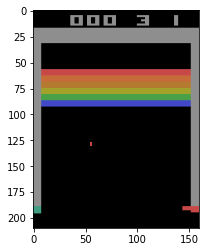

In [21]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = optim.Adam(model_target.parameters(), lr=0.00025,)
loss_fn = nn.SmoothL1Loss()
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability


while True:  # Run until solved
    env.reset()
    state = np.array(env.reset())
    
    img = plt.imshow(env.render('rgb_array'))
    state=np.moveaxis(state, -1, 0)
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        img.set_data(env.render('rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)

        #Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1
        
        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            with torch.no_grad():
              X_batch = Variable(torch.from_numpy(state))
              X_batch=X_batch.float()
              X_batch=torch.unsqueeze(X_batch,dim=0).to(device)
              action_probs = model(X_batch)
              # Take best action
              action = torch.argmax(action_probs[0]).cpu().numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)
        state_next=np.moveaxis(state_next, -1, 0)
        reward = np.array(reward)
        

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)

        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)
          

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = np.array([rewards_history[i] for i in indices])
            action_sample = [action_history[i] for i in indices]
            done_sample = torch.from_numpy(np.array([float(done_history[i]) for i in indices]))
            

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            state_next_sample = Variable(torch.from_numpy(state_next_sample))
            state_next_sample=state_next_sample.float()
            state_next_sample=state_next_sample.to(device)
            future_rewards = model_target(state_next_sample)
            

            # Q value = reward + discount factor * expected future reward
            
            updated_q_values = torch.from_numpy(rewards_sample).to(device) + gamma * torch.max(future_rewards,1)[0]
            

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample.to(device)) - done_sample.to(device)
            
            # Create a mask so we only calculate loss on the updated Q-values
            

            masks =  functional.one_hot(torch.tensor(np.array(action_sample)), num_classes=num_actions)
            

        
            # Train the model on the states and updated Q-values
            
           
            state_sample = Variable(torch.from_numpy(state_sample))
            state_sample=state_sample.float()
            state_sample=state_sample.to(device)
            q_values = model(state_sample)
            
          

            # Apply the masks to the Q-values to get the Q-value for action taken
            q_action = torch.sum(torch.mul(q_values.to(device), masks.to(device)), axis=1)
            # Calculate loss between new Q-value and old Q-value

            # Backpropagation
            loss = loss_fn(updated_q_values.double(), q_action.double())
            optimizer.zero_grad()
            loss.backward()
            for param in model.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()



        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            #model_target.set_weights(model.get_weights())
            model_target.load_state_dict(model.state_dict())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break